# **Importing project dependencies**

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

# **Dataset loading**

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip

--2024-04-30 03:05:03--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.199, 16.12.36.11, 52.219.158.171, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip.1’

driver_drowsiness_d 100%[===================>] 121.53M  11.6MB/s    in 13s     

2024-04-30 03:05:17 (9.21 MB/s) - ‘driver_drowsiness_detection_modified.zip.1’ saved [127436131/127436131]



# **Image resizing**

In [ ]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [ ]:
def rgb_to_grayscale(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Use BGR2GRAY since OpenCV loads images in BGR format
    # Add a new axis to make it 3-dimensional
    gray_image = np.expand_dims(gray_image, axis=-1)
    return gray_image


In [ ]:

for i in range(len(X)):
    img = X[i]
    img = rgb_to_grayscale(img)
    X[i]=img


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/MyDrive/train2")

os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/train2'

In [ ]:


def read_images_from_folder(folder_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image using OpenCV in grayscale mode
            image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            # Resize the image to the target size
            image_resized = cv2.resize(image, target_size)
            # Add a channel dimension to make it 3D
            image_reshaped = np.expand_dims(image_resized, axis=-1)
            # Append the image to the list
            images.append(image_reshaped)
    # Convert the list of images to a numpy array
    images_array = np.array(images)
    return images_array

# Specify the folder containing the images
folder_path = "/content/gdrive/MyDrive/train2/closed"

# Read images from the folder
images_array = read_images_from_folder(folder_path)
X_2=images_array
# Check the shape of the resulting array

In [ ]:
X_2.shape

(700, 128, 128, 1)

In [ ]:


def read_images_from_folder(folder_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image using OpenCV in grayscale mode
            image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            # Resize the image to the target size
            image_resized = cv2.resize(image, target_size)
            # Add a channel dimension to make it 3D
            image_reshaped = np.expand_dims(image_resized, axis=-1)
            # Append the image to the list
            images.append(image_reshaped)
    # Convert the list of images to a numpy array
    images_array = np.array(images)
    return images_array

# Specify the folder containing the images
folder_path = "/content/gdrive/MyDrive/train2/open"

# Read images from the folder
images_array = read_images_from_folder(folder_path)
X_3=images_array
# Check the shape of the resulting array

In [ ]:
X_3.shape

(700, 128, 128, 1)

In [ ]:
# Create two sample arrays
array1 = X_2
array2 = X_3

# Create a new array with the desired shape
new_shape = (array1.shape[0] + array2.shape[0], array1.shape[1], array1.shape[2], array1.shape[3])
X_new = np.zeros(new_shape)

# Copy contents of array1 and array2 into result_array
X_new[:array1.shape[0], :, :, :] = array1
X_new[array1.shape[0]:, :, :, :] = array2

print("Resulting array shape:", X_new.shape)


Resulting array shape: (1400, 128, 128, 1)


In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)

print(set(Y))

(1452,)
{0, 1}


In [ ]:
label_encoder.classes_

array(['Closed', 'Open'], dtype='<U6')

In [ ]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 128, 128, 1)
(1452,)


In [ ]:
import numpy as np

# Create two sample arrays
array1 = X
array2 = X_new

# Create a new array with the desired shape
new_shape = (array1.shape[0] + array2.shape[0], array1.shape[1], array1.shape[2], array1.shape[3])
X_final = np.zeros(new_shape)

# Copy contents of array1 and array2 into result_array
X_final[:array1.shape[0], :, :, :] = array1
X_final[array1.shape[0]:, :, :, :] = array2

print("Resulting array shape:", X_final.shape)

Resulting array shape: (2852, 128, 128, 1)


In [ ]:
import numpy as np

# Create an array of shape (700,) filled with zeros
zeros_array = np.zeros((700,), dtype=np.int64)

# Create an array of shape (700,) filled with ones
ones_array = np.ones((700,), dtype=np.int64)

# Concatenate zeros and ones arrays along the first axis
Y_5 = np.concatenate((zeros_array, ones_array))

print("Shape of the result array:", Y_5.shape)



Shape of the result array: (1400,)


In [ ]:
Y_final = np.concatenate((Y, Y_5))
Y_final.shape

(2852,)

# **Data set split**

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_temp, Y_train, Y_temp = train_test_split(X_final, Y_final, test_size=0.40)


X_validation, X_test, Y_validation, Y_test = train_test_split(X_temp, Y_temp, test_size=0.7)

<ipython-input-72-85539d9fe845>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_train, y=count,palette="muted").set_title("Number of training images per category:")


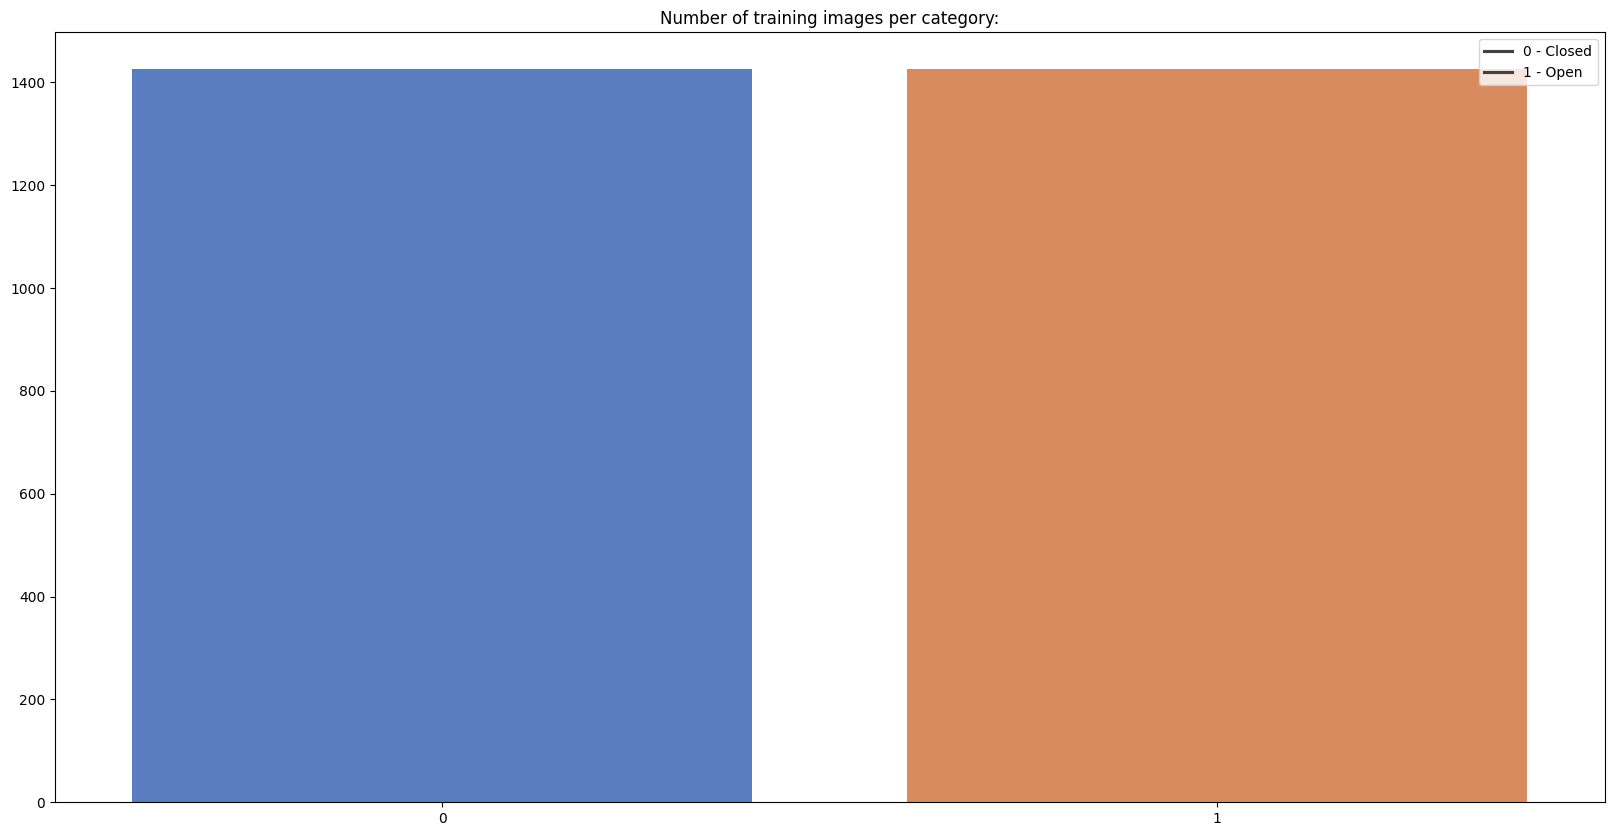

array([1426, 1426])

In [ ]:
# Create a bar plot to visualize the distribution
unique_train, count = np.unique(Y_final, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count,palette="muted").set_title("Number of training images per category:")
legend_labels = ['0 - Closed', '1 - Open']
plt.legend(legend_labels, loc='upper right')
plt.show()
count

<ipython-input-73-fcacfe4fe3ae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")


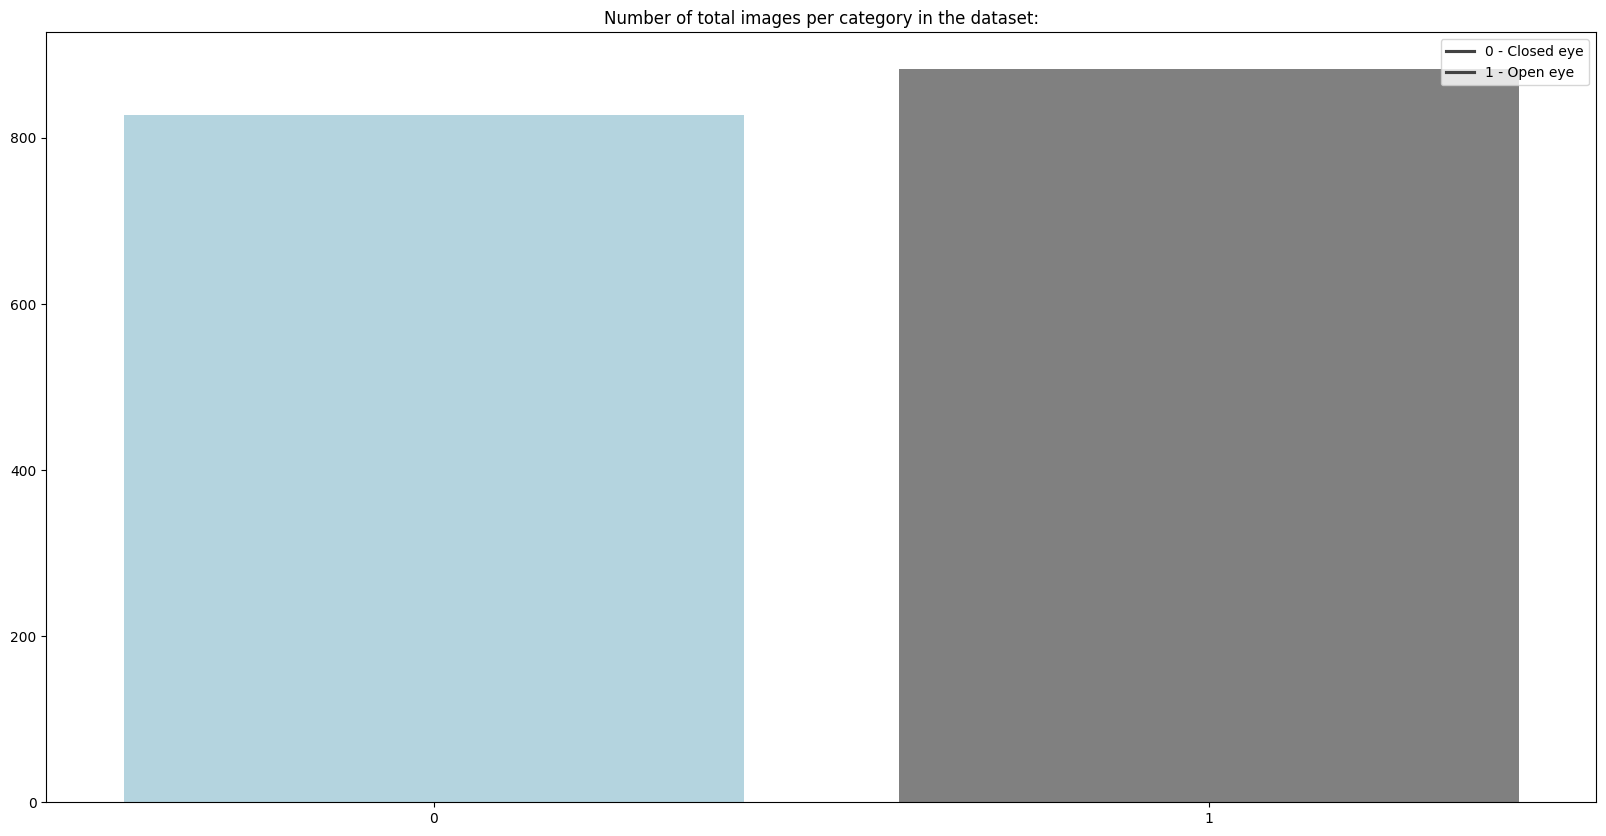

array([828, 883])

In [ ]:
unique_test, count_test = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
colors = ["lightblue", "grey"]
sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")
legend_labels=['0 - Closed eye', '1 - Open eye']
plt.legend(legend_labels, loc='upper right')
plt.show()
count_test

<ipython-input-74-3ae133774be8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")


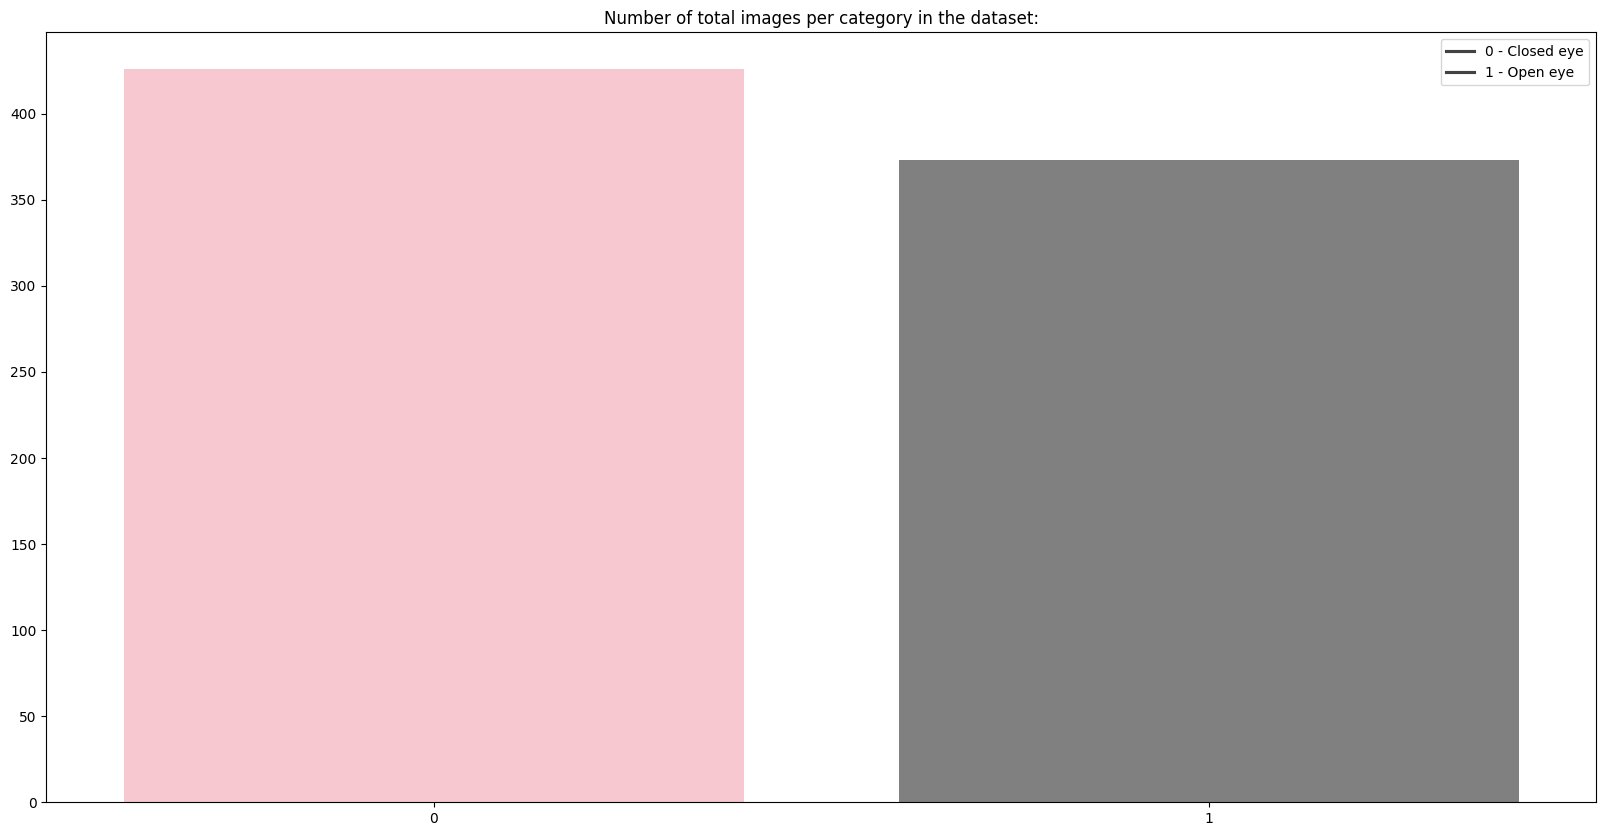

array([426, 373])

In [ ]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
colors = ["pink", "grey"]
sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")
legend_labels=['0 - Closed eye', '1 - Open eye']
plt.legend(legend_labels, loc='upper right')
plt.show()
count_test

<ipython-input-75-6ed109feb836>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")


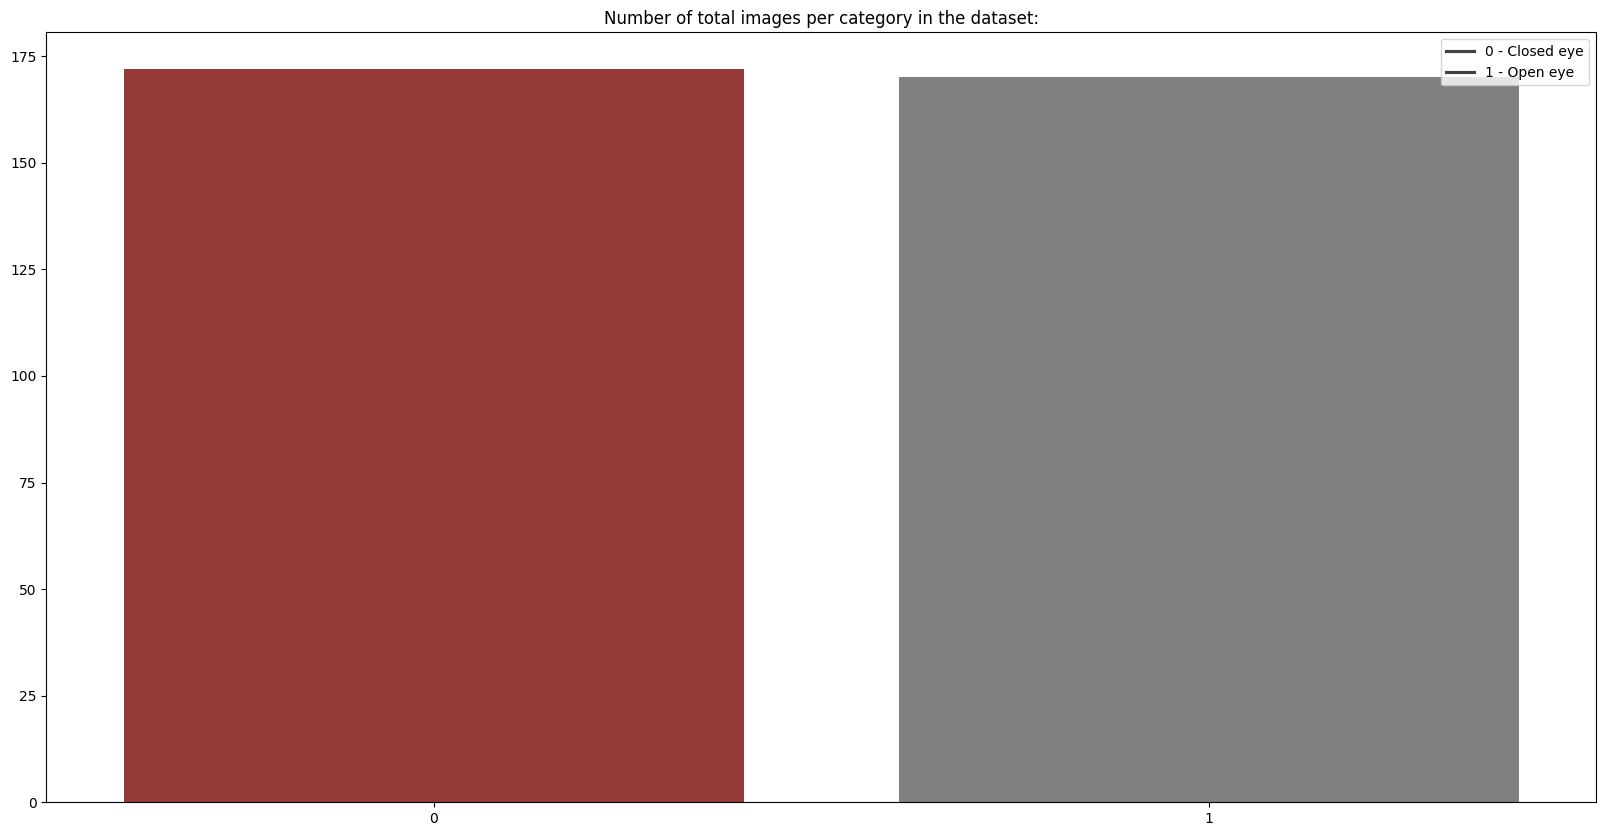

array([172, 170])

In [ ]:
unique_test, count_test = np.unique(Y_validation, return_counts=True)
plt.figure(figsize=(20, 10))
colors = ["brown", "grey"]
sns.barplot(x=unique_test, y=count_test,palette=colors).set_title("Number of total images per category in the dataset:")
legend_labels=['0 - Closed eye', '1 - Open eye']
plt.legend(legend_labels, loc='upper right')
plt.show()
count_test

In [ ]:
print("Train")
print(X_train.shape)
print(Y_train.shape)

print("Test")
print(X_test.shape)
print(Y_test.shape)

print("validate")
print(X_validation.shape)
print(Y_validation.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_validation=to_categorical(Y_validation)

print("Train")
print(X_train.shape)
print(Y_train.shape)

print("Test")
print(X_test.shape)
print(Y_test.shape)

print("validate")
print(X_validation.shape)
print(Y_validation.shape)



Train
(1711, 128, 128, 1)
(1711,)
Test
(799, 128, 128, 1)
(799,)
validate
(342, 128, 128, 1)
(342,)
Train
(1711, 128, 128, 1)
(1711, 2)
Test
(799, 128, 128, 1)
(799, 2)
validate
(342, 128, 128, 1)
(342, 2)


# **Sample images in each category**

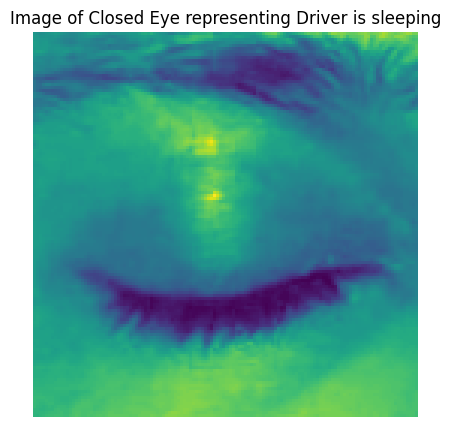

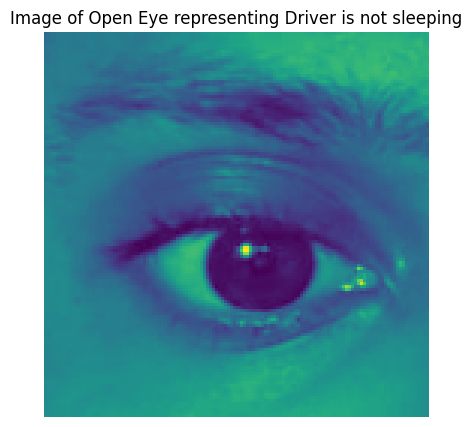

In [ ]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y_final==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y_final==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

# **Model**

In [ ]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(84, (3, 3), activation='relu', input_shape=(128, 128, 1)))  # Assuming input images are RGB
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 2
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 3
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 4
model.add(Conv2D(512, (5, 5), activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=(2, 2)))
# model.add(Dropout(0.25))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))

# Output Layer
model.add(Dense(2, activation='softmax'))  # Assuming two output classes (binary classification)



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 84)      840       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 84)      336       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 84)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 84)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 59, 59, 128)       268928    
                                                                 
 batch_normalization_9 (Bat  (None, 59, 59, 128)      

In [ ]:
# def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(MaxPool2D((2, 2), strides=(2, 2)))

#     model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides=(2, 2)))
#     model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(MaxPool2D((2, 2), strides=(2, 2)))

#     model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu',
#                      kernel_initializer=glorot_uniform(seed=0)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.4))
#     model.add(MaxPool2D((2, 2), strides=(2, 2)))


#     model.add(Flatten())
#     model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

#     optimizer = Adam(0.0001)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=50, validation_data=(X_validation, Y_validation))

Epoch 1/50
14/14 [==============================] - 15s 906ms/step - loss: 4.7156 - accuracy: 0.7960 - val_loss: 1845.9390 - val_accuracy: 0.4971
Epoch 2/50
14/14 [==============================] - 5s 374ms/step - loss: 0.9137 - accuracy: 0.9112 - val_loss: 1290.1782 - val_accuracy: 0.4971
Epoch 3/50
14/14 [==============================] - 5s 369ms/step - loss: 0.4496 - accuracy: 0.9474 - val_loss: 111.4354 - val_accuracy: 0.5058
Epoch 4/50
14/14 [==============================] - 5s 365ms/step - loss: 0.2429 - accuracy: 0.9439 - val_loss: 43.5269 - val_accuracy: 0.6462
Epoch 5/50
14/14 [==============================] - 5s 375ms/step - loss: 0.1582 - accuracy: 0.9608 - val_loss: 53.6987 - val_accuracy: 0.6901
Epoch 6/50
14/14 [==============================] - 5s 373ms/step - loss: 0.1884 - accuracy: 0.9591 - val_loss: 6.4865 - val_accuracy: 0.8070
Epoch 7/50
14/14 [==============================] - 5s 378ms/step - loss: 0.2693 - accuracy: 0.9451 - val_loss: 26.3487 - val_accuracy: 0

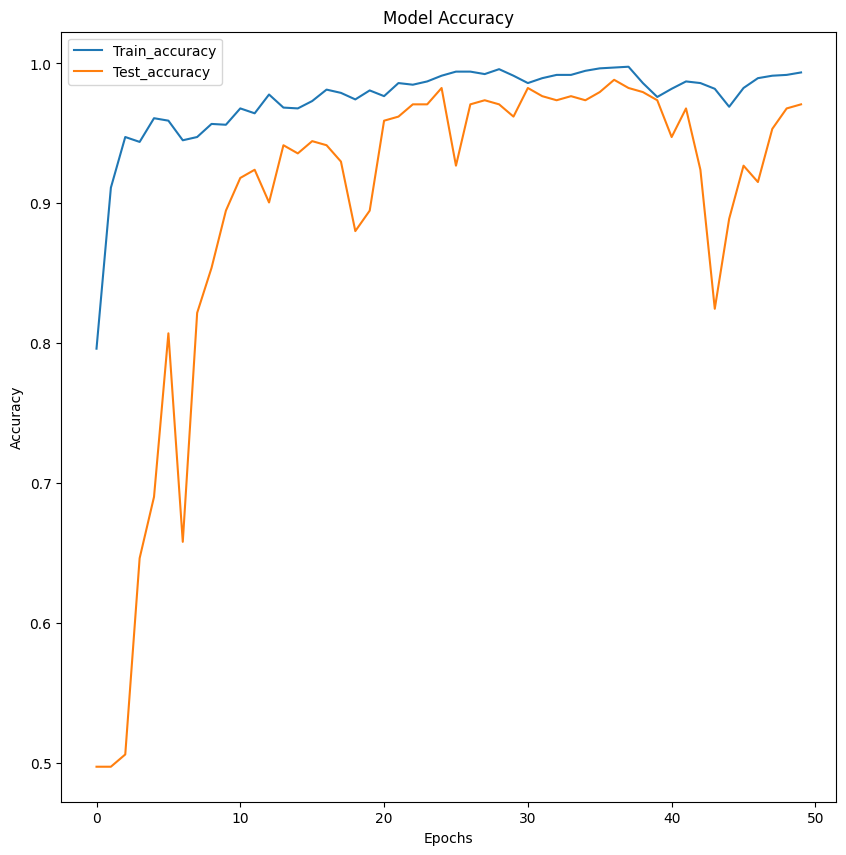

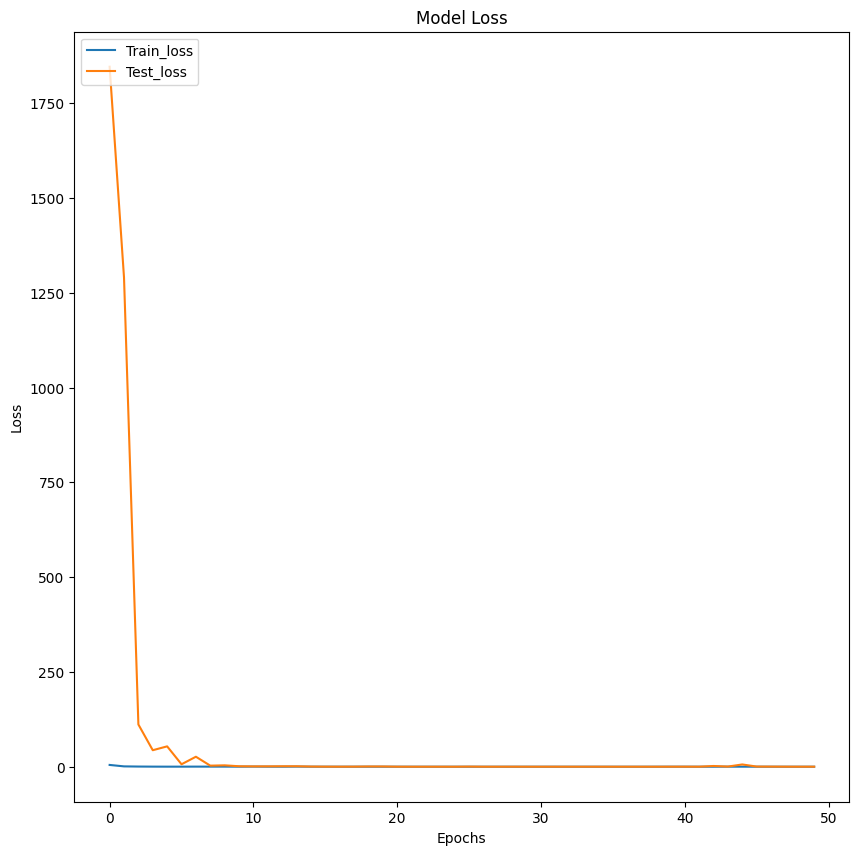

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

# **Performance evaluation**

In [ ]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

25/25 [==============================] - 1s 19ms/step - loss: 0.2615 - accuracy: 0.9825
Test Set Accuracy: 0.9824780821800232
Test Set Loss: 0.2615313231945038


In [ ]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

25/25 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       426
           1       0.98      0.99      0.98       373

    accuracy                           0.98       799
   macro avg       0.98      0.98      0.98       799
weighted avg       0.98      0.98      0.98       799



<Axes: >

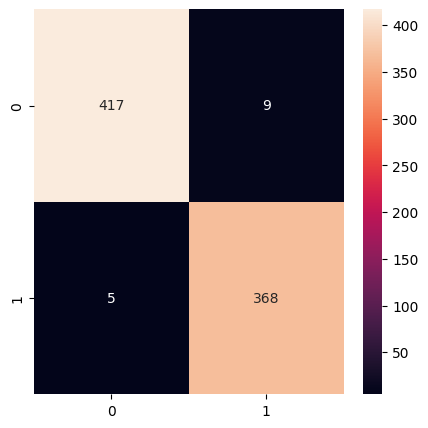

In [ ]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/MyDrive/Drowsiness")

os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/Drowsiness'

In [ ]:
model_save_name = 'Driver_Drowsiness_Detection_Paper_50_98A.keras'
path = f"/content/gdrive/MyDrive/Drowsiness/"
model.save(model_save_name, path)

In [ ]:
def rgb_to_grayscale(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Use BGR2GRAY since OpenCV loads images in BGR format
    # Add a new axis to make it 3-dimensional
    gray_image = np.expand_dims(gray_image, axis=-1)
    return gray_image


In [ ]:
labels = ['Closed', 'Open']
img_closed2 = cv2.imread('/content/driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('/content/driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('/content/driver_drowsiness_detection/open_eye2.jpg')


img_closed2 = cv2.resize(img_closed2, (128, 128))
img_open1 = cv2.resize(img_open1, (128, 128))
img_open2 = cv2.resize(img_open2, (128, 128))



img_closed2 = rgb_to_grayscale(img_closed2)
img_open1   = rgb_to_grayscale(img_open1)
img_open2   = rgb_to_grayscale(img_open2)


img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)


img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)



In [ ]:

ypred_closed2= model.predict(img_closed2)
ypred_open1=model.predict(img_open1)
ypred_open2=model.predict(img_open2)

1/1 [==============================] - 0s 31ms/step


# **Model predictions**

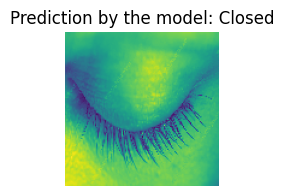

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

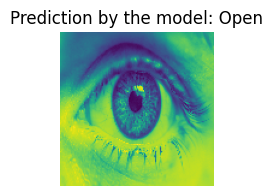

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

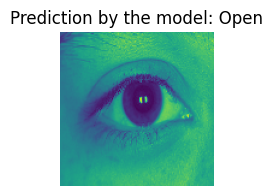

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()
